# Group 6 Benson

### Import Packages and MTA Data

In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import chisquare
plt.style.use('fivethirtyeight')

In [2]:
files = ['170701', '170624', '170617', '170610','170603', '170527', '170520', '170513', '170506',
         '160702', '160625', '160618', '160611','160604', '160528', '160521', '160514', '160507']

myFrames = []
for date in files:
    print(f'Collecting file {files.index(date)+1} out of {len(files)}')
    df = pd.read_csv(f'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{date}.txt')
    myFrames.append(df)

### Clean the data

In [3]:
mtaDataDf = pd.concat(myFrames).reset_index()
mtaDataDf.columns = [x.strip().lower() for x in mtaDataDf.columns]
mtaDataDf.linename = mtaDataDf.linename.apply(sorted)
mtaDataDf.linename = mtaDataDf.linename.apply(''.join)
mtaDataDf['turnstile'] = mtaDataDf['c/a'] + '_' + mtaDataDf.scp
mtaDataDf['datetimestr'] = mtaDataDf.date + ' ' + mtaDataDf.time

In [4]:
mtaDataDf['datetime'] = pd.to_datetime(mtaDataDf.datetimestr, infer_datetime_format=True)
mtaDataDf.date = pd.to_datetime(mtaDataDf.date, infer_datetime_format=True)

In [5]:
mtaDataDf['month'] = mtaDataDf.date.apply(lambda x: x.month)
mtaDataDf['hour'] = mtaDataDf.datetime.apply(lambda x: x.hour)
mtaDataDf.loc[mtaDataDf.station == '14 ST-UNION SQ', 'hour'] -= 1
mtaDataDf.loc[(mtaDataDf.hour <= 4) & (mtaDataDf.hour > 0), 'bin'] = 1
mtaDataDf.loc[(mtaDataDf.hour <= 8) & (mtaDataDf.hour > 4), 'bin'] = 2
mtaDataDf.loc[(mtaDataDf.hour <= 12) & (mtaDataDf.hour > 8), 'bin'] = 3
mtaDataDf.loc[(mtaDataDf.hour <= 16) & (mtaDataDf.hour > 12), 'bin'] = 4
mtaDataDf.loc[(mtaDataDf.hour <= 20) & (mtaDataDf.hour > 16), 'bin'] = 5
mtaDataDf.loc[(mtaDataDf.hour == 0) | (mtaDataDf.hour > 20), 'bin'] = 6

In [6]:
mtaMayJune = mtaDataDf[(mtaDataDf.month == 5) | (mtaDataDf.month == 6)]
mtaMayJune['weekdaynum'] = mtaMayJune.date.apply(lambda x: x.weekday())
mtaMayJune.loc[mtaMayJune.weekdaynum <= 5, 'weekday'] = 1
mtaMayJune.loc[mtaMayJune.weekdaynum > 5, 'weekday'] = 0
mtaMayJune['total_pass'] = mtaMayJune.entries + mtaMayJune.exits
mtaMayJune.sort_values(['datetime', 'turnstile'],inplace=True)

/home/parker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/parker/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/parker/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [7]:
groupedMtaDataDf = mtaMayJune
groupedMtaDataDf['changepass'] = mtaMayJune.groupby(['turnstile'])['total_pass'].diff()
groupedMtaDataDf = groupedMtaDataDf.reset_index()
groupedMtaDataDf['timedif'] = groupedMtaDataDf.groupby(['turnstile'])['datetime'].diff()
groupedMtaDataDf['timedif'] = groupedMtaDataDf.timedif.apply(lambda x: x.total_seconds())

/home/parker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
groupedMtaDataDf.dropna(inplace=True)
groupedMtaDataDf.drop_duplicates(keep='first',inplace=True)

In [9]:
cleanMtaDataDf = groupedMtaDataDf
cleanMtaDataDf['passpersec'] = cleanMtaDataDf.changepass / cleanMtaDataDf.timedif 
cleanMtaDataDf = cleanMtaDataDf[(cleanMtaDataDf.passpersec > 0) & (cleanMtaDataDf.passpersec <1)]
cleanMtaDataDf = cleanMtaDataDf[cleanMtaDataDf.timedif < 26270000.0]
cleanMtaDataDf.loc[cleanMtaDataDf.station == '34 ST-HERALD SQ', 'linename'] = 'BDFMNQRW'

### Plot the Data

###### Set up default Plot Data Frame

In [10]:
plotCols = ['station','linename','turnstile','weekday', 'month','bin','changepass','timedif', 'c/a', 'hour','date','weekdaynum']
plotDf = cleanMtaDataDf[plotCols]
plotDf['uniquestation'] = plotDf.station + '_' + plotDf.linename

/home/parker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


###### Plot and compare passenger flow on weekday vs. weekend

In [11]:
plotDfWeek = plotDf.groupby(['bin','weekday'])[['changepass','timedif']].sum().reset_index().copy()
plotDfWeek['avgpass'] = plotDfWeek.changepass * 3600 / plotDfWeek.timedif #average passengers per hour
plotDfWeek.sort_values(['weekday', 'bin'],inplace=True)

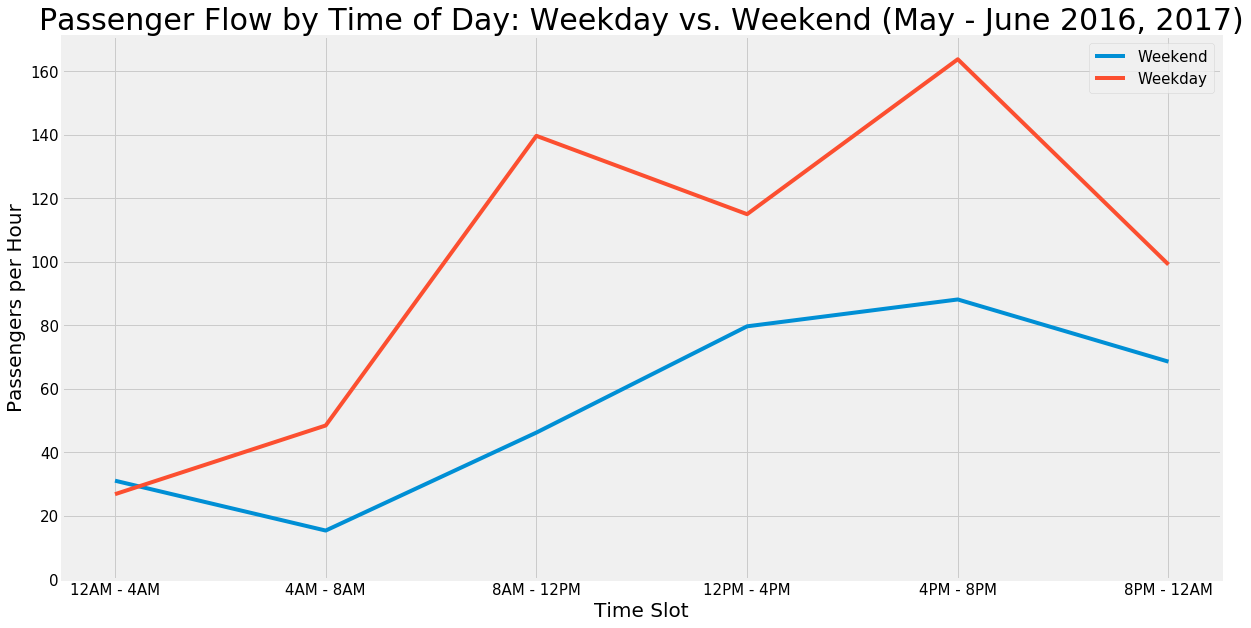

In [12]:
avgPass = list(plotDfWeek.avgpass)
fig, ax = plt.subplots()
theLegend = ['Weekend', 'Weekday']
bins = list(range(6))
binLabels = ['12AM - 4AM', '4AM - 8AM', '8AM - 12PM', '12PM - 4PM', '4PM - 8PM', '8PM - 12AM']
weekendPass = avgPass[:6]
weekdayPass = avgPass[6:]

ax.plot(bins, weekendPass)
ax.plot(bins, weekdayPass)
ax.legend(theLegend, fontsize=15)
ax.set_xticks(bins)
plt.ylim(ymin=0)
ax.tick_params(labelsize=15)
ax.set_xticklabels(binLabels)
ax.set_xlabel('Time Slot',fontsize=20)
ax.set_ylabel('Passengers per Hour',fontsize=20)
ax.set_title('Passenger Flow by Time of Day: Weekday vs. Weekend (May - June 2016, 2017)',fontsize=30)
fig.set_size_inches(18.5, 10)

In [13]:
plotDfCondenseStation = plotDf.groupby(['uniquestation'])[['changepass','timedif']].sum().reset_index().copy()
plotDfCondenseStation.sort_values('changepass',inplace=True,ascending=False)
plotDfWeekday = plotDf.groupby(['uniquestation', 'weekdaynum'])[['changepass','timedif']].sum().reset_index().copy()
plotDfWeekday['avgpass'] = plotDfWeekday.changepass * 3600 / plotDfWeekday.timedif #average passengers per hour
topStations = list(plotDfCondenseStation.head(10).uniquestation)

###### Find top 10 stations in the sample

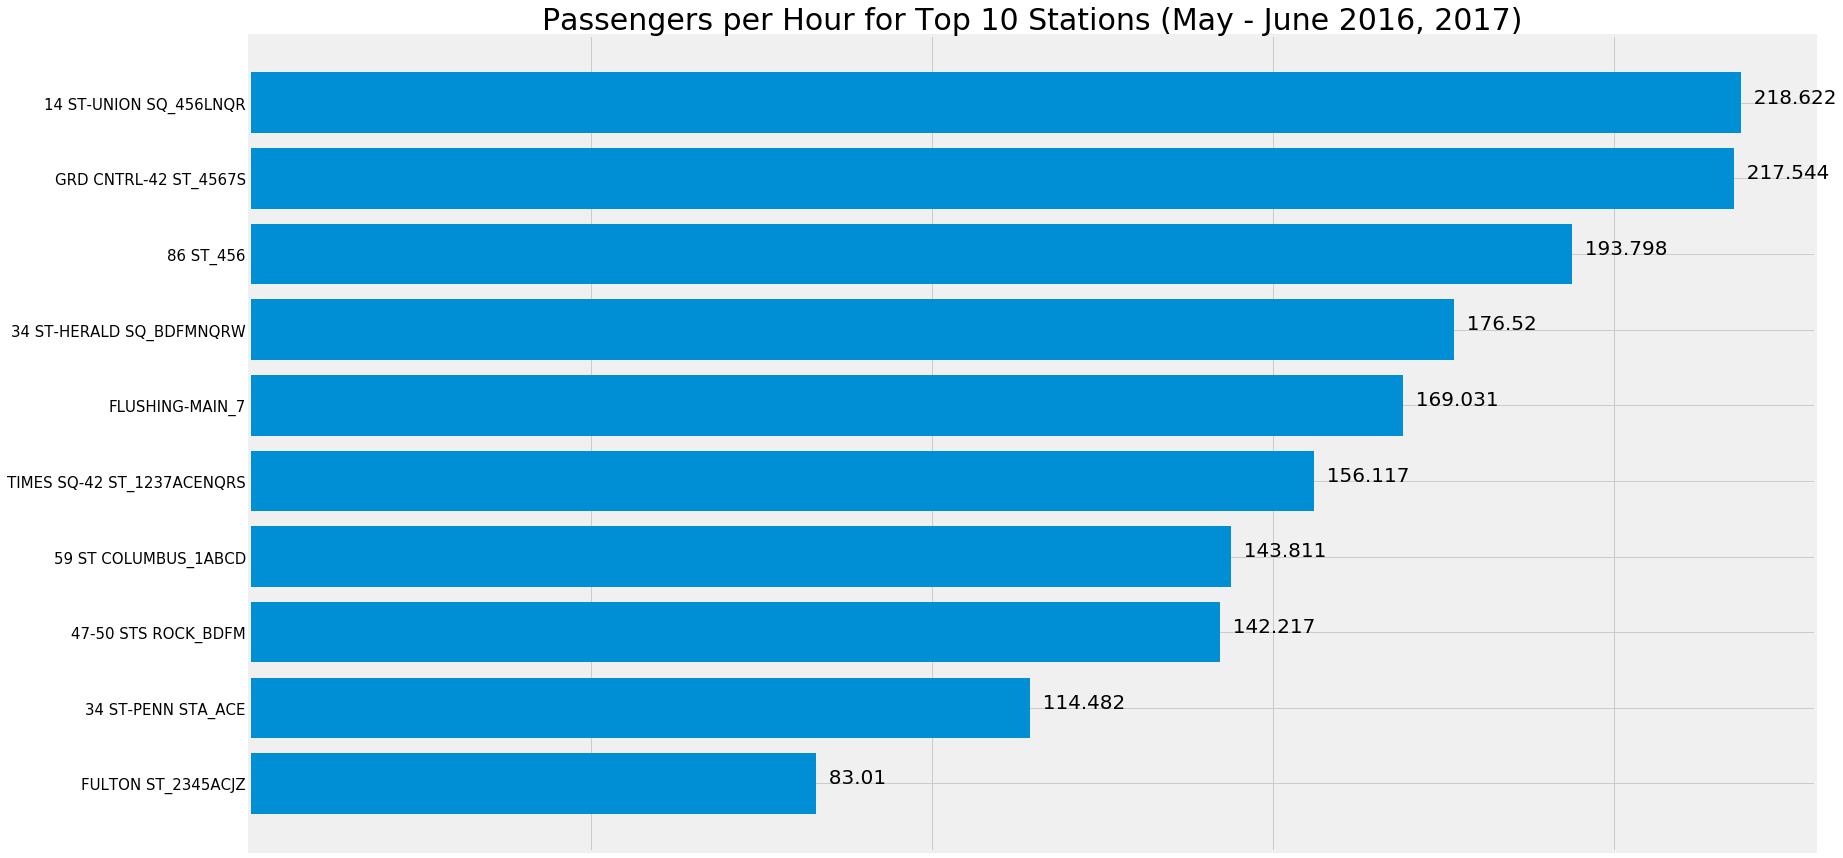

In [14]:
#Plot weekly comparison
plotDfCondense = plotDf.groupby(['uniquestation','weekday'])[['changepass','timedif']].sum().reset_index().copy()
plotDfCondense['avgpass'] = plotDfCondense.changepass * 3600 / plotDfCondense.timedif #average passengers per hour

plotDfCondense.sort_values('avgpass',inplace=True,ascending=True)
plotDfCondense = plotDfCondense[(plotDfCondense.uniquestation.isin(topStations)) & plotDfCondense.weekday ==1]

fig, ax = plt.subplots()
stationsTop10 = list(plotDfCondense.uniquestation)
valuesTop10 = list(plotDfCondense.avgpass)
y_pos = len(stationsTop10)
index = list(range(len(stationsTop10)))
ax.barh(index, valuesTop10)
ax.set_yticks(index)
ax.set_yticklabels(stationsTop10, fontsize=20)
ax.set_xticklabels('')
ax.set_title('Passengers per Hour for Top 10 Stations (May - June 2016, 2017)', fontsize=30)
ax.tick_params(labelsize=15)



for i, v in enumerate(valuesTop10):
    ax.text(v, i, '  ' + str(round(v,3)), color='black',fontsize=20)

fig.set_size_inches(25, 15)


###### Plot and compare individual weekdays for top 10 stations

/home/parker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


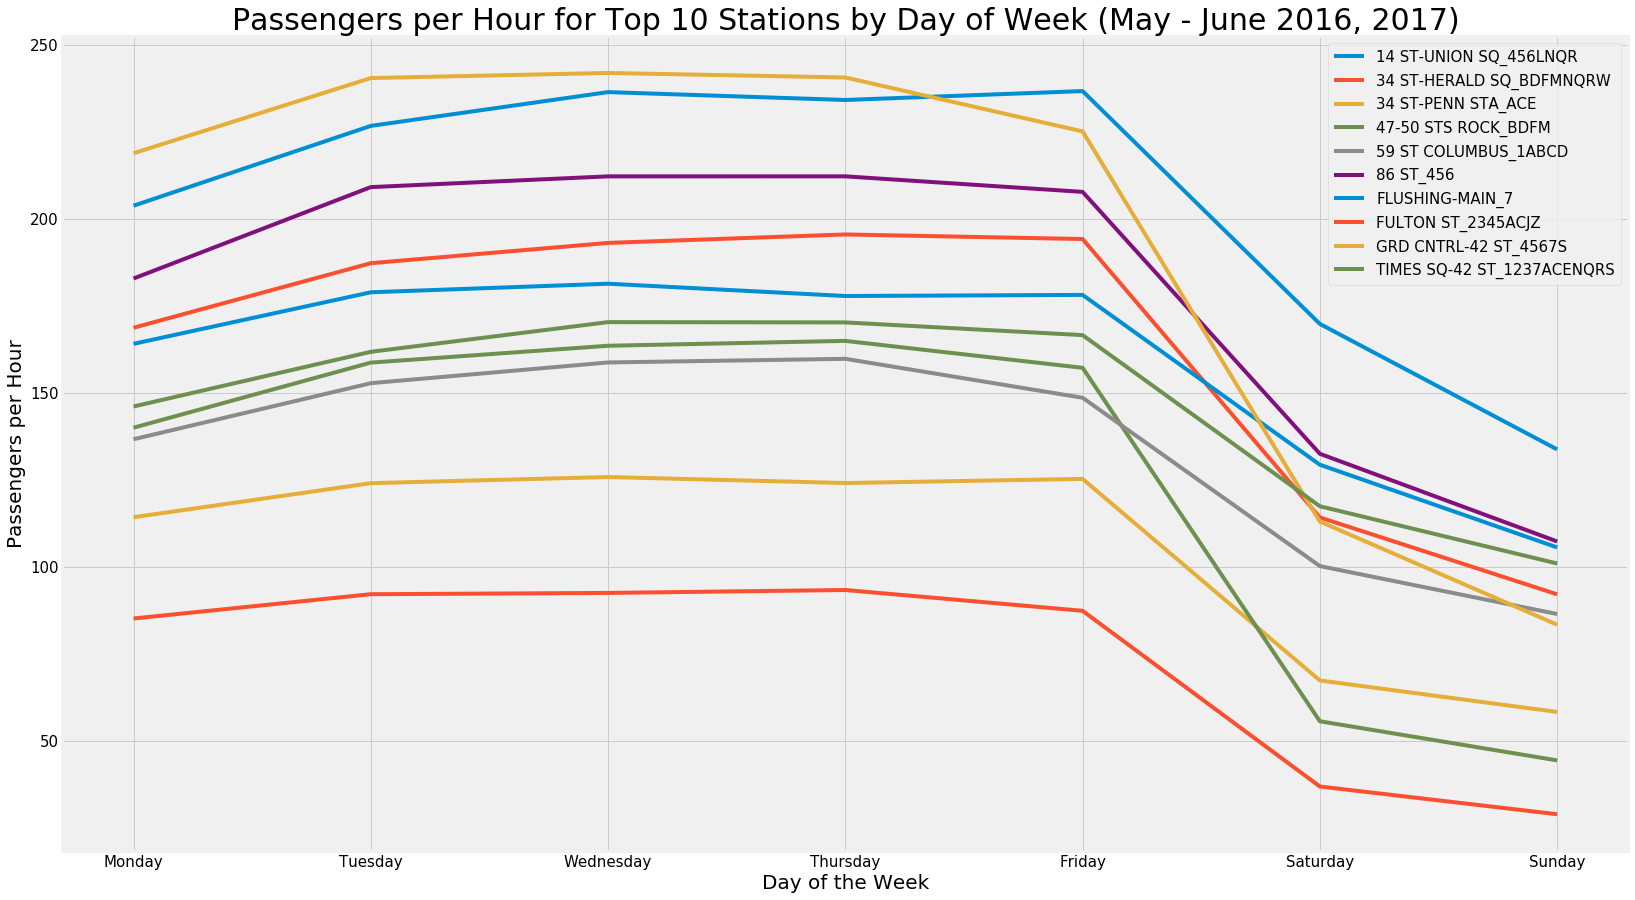

In [15]:
plotDfWeekday10 = plotDfWeekday[plotDfWeekday.uniquestation.isin(topStations)]
plotDfWeekday10.sort_values(['uniquestation', 'weekdaynum'],inplace=True)
theStations = []
for station in list((plotDfWeekday10.uniquestation)):
    if station not in theStations:
        theStations.append(station)
myBins = list(plotDfWeekday10.weekdaynum)
thePass = list(plotDfWeekday10.avgpass)

fig, ax = plt.subplots()
theLegend = []
binLabels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
passVals = []
for i in range(len(theStations)):
    passList = thePass[i*7:(i*7 + 7)]
    binList = myBins[i*7:(i*7 + 7)]
    theLegend.append(theStations[i])
    ax.plot(binList, passList)
ax.legend(theLegend,fontsize=15)
ax.set_xticks(binList)
ax.set_xticklabels(binLabels)
ax.tick_params(labelsize=15)
ax.set_xlabel('Day of the Week',fontsize=20)
ax.set_ylabel('Passengers per Hour',fontsize=20)
ax.set_title(f'Passengers per Hour for Top {len(theStations)} Stations by Day of Week (May - June 2016, 2017)',fontsize=30)
fig.set_size_inches(25, 15)

###### Plot passenger flow for each station

In [16]:
def plot_stations(stations, passengers,theBins, legend=True):
    fig, ax = plt.subplots()
    theLegend = []
    binLabels = ['12AM - 4AM', '4AM - 8AM', '8AM - 12PM', '12PM - 4PM', '4PM - 8PM', '8PM - 12AM']
    passVals = []
    binList = range(1,7)
    for i in range(len(stations)):
        passList = passengers[i*6:(i*6 + 6)]
        theLegend.append(stations[i])
        ax.plot(binList, passList)
    if legend:
        ax.legend(theLegend,fontsize=15)
    ax.set_xticks(binList)
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(binLabels)
    ax.set_xlabel('Time Slot',fontsize=20)
    ax.set_ylabel('Passengers per Hour',fontsize=20)
    ax.set_title(f'Passengers per Hour for Top {len(stations)} Stations Over Time (May - June 2016, 2017)',fontsize=30)
    fig.set_size_inches(25, 15)

In [17]:
plotDfCondenseBins = plotDf.groupby(['uniquestation','weekday'])[['changepass','timedif']].sum().reset_index().copy()
plotDfCondenseBins.sort_values('changepass',inplace=True,ascending=False)
plotDfBins = plotDf.groupby(['uniquestation', 'bin','weekday'])[['changepass','timedif']].sum().reset_index().copy()
plotDfBins['avgpass'] = plotDfBins.changepass * 3600 / plotDfBins.timedif #average passengers per hour

/home/parker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


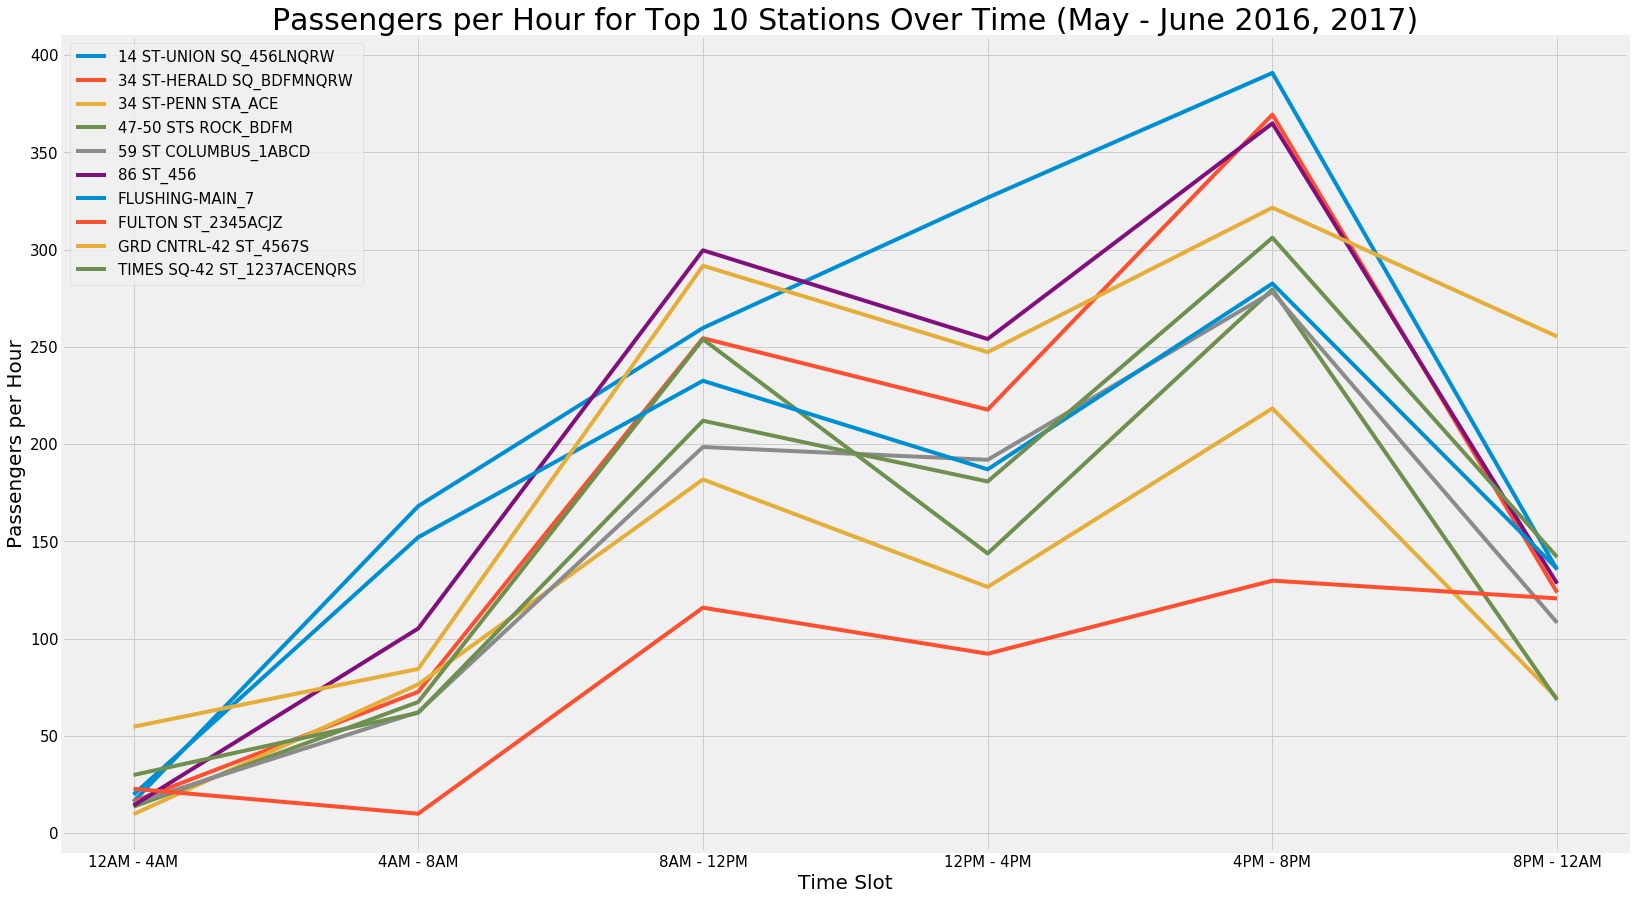

In [18]:
topStations = list(plotDfCondenseBins.head(10).uniquestation)
plotDfBins10 = plotDfBins[plotDfBins.uniquestation.isin(topStations)]
plotDfBins10.sort_values(['uniquestation', 'bin'],inplace=True)
plotDfBins10 = plotDfBins10[plotDfBins10.weekday == 1]
theStations = []
for station in list((plotDfBins10.uniquestation)):
    if station not in theStations:
        theStations.append(station)
myBins = list(plotDfBins10.bin)
thePass = list(plotDfBins10.avgpass)
plot_stations(theStations, thePass, myBins, True)

###### Plot passenger flow by entrance for each station

In [19]:
def plot_booth(booth_df, theStation, legend=True):
    fig, ax = plt.subplots()
    theLegend = []
    newDf = booth_df[booth_df.uniquestation == theStation].copy()
    newDf = newDf.groupby(['uniquestation', 'c/a', 'bin'])[['changepass','timedif']].sum().reset_index()
    newDf['avgpass'] = newDf.changepass * 3600 / newDf.timedif #average passengers per hour
    newDf.sort_values(['c/a', 'bin'],inplace=True)
    passengers = list(newDf.avgpass)
    binLabels = ['12AM - 4AM', '4AM - 8AM', '8AM - 12PM', '12PM - 4PM', '4PM - 8PM', '8PM - 12AM']
    passVals = []
    theBins = list(newDf.bin)
    booths = []
    
    for booth in list(newDf['c/a']):
        if booth not in booths:
            booths.append(booth)
    for i in range(len(booths)):
        mapping = [x == booths[i] for x in list(newDf['c/a'])]
        passList = [theVal for (theVal, mapped) in zip(passengers, mapping) if mapped]        
        binList = [theVal for (theVal, mapped) in zip(theBins, mapping) if mapped]  
        missing_bins = []
        for the_bin in range(1,7):
            if the_bin not in binList:
                missing_bins.append(the_bin)        
        for the_bin in missing_bins:
            ind = 0
            placed = False
            while ind < len(binList) and not placed:
                if the_bin < binList[ind]:
                    passList.insert(ind, 0)
                    binList.insert(ind, the_bin)
                    placed = True
                ind += 1
        theLegend.append(booths[i])
        ax.plot(binList, passList)
    if legend:
        ax.legend(theLegend,fontsize=15)
    ax.set_xticks(binList)
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(binLabels)
    ax.set_xlabel('Time Slot', fontsize=20)
    ax.set_ylabel('Passengers per Hour', fontsize=20)
    ax.set_title(f'Passenger per Hour for Booths at {theStation} Over Time (May - June 2016, 2017)', fontsize=25)
    fig.set_size_inches(25, 15)

In [20]:
print(topStations)

['GRD CNTRL-42 ST_4567S', '34 ST-HERALD SQ_BDFMNQRW', 'FULTON ST_2345ACJZ', '34 ST-PENN STA_ACE', '59 ST COLUMBUS_1ABCD', '47-50 STS ROCK_BDFM', 'FLUSHING-MAIN_7', 'TIMES SQ-42 ST_1237ACENQRS', '86 ST_456', '14 ST-UNION SQ_456LNQRW']


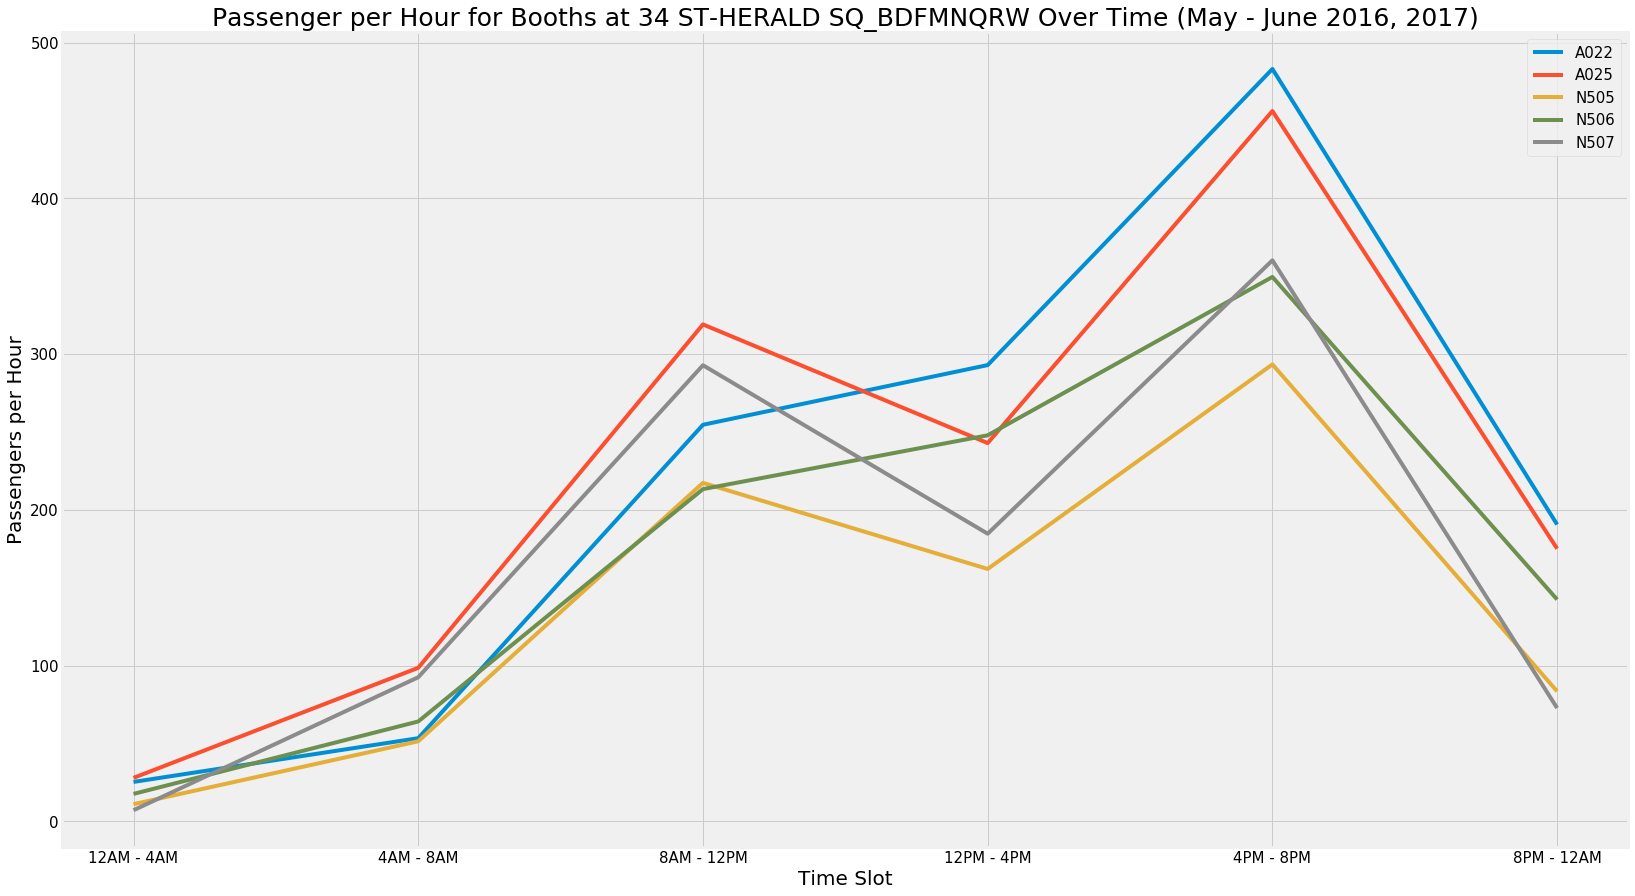

In [21]:
plotDfTurn = plotDf[plotDf.weekday == 1].copy() 
plotDfTurn = plotDfTurn.groupby(['uniquestation', 'c/a', 'bin','linename'])[['changepass','timedif']].sum().reset_index()
plotDfTurn['avgpass'] = plotDfTurn.changepass * 3600 / plotDfTurn.timedif #average passengers per hour
plotDfTurn.sort_values(['c/a', 'bin'],inplace=True)
plot_booth(plotDfTurn, topStations[1])

### Analyze the data

###### Find the best entrance for each station in each time slot

In [22]:
times = ['12AM - 4AM', '4AM - 8AM', '8AM - 12PM', '12PM - 4PM', '4PM - 8PM', '8PM - 12AM']
plotDfTurnMaxBooth = plotDfTurn.groupby(['uniquestation','bin'])[['avgpass']].max().reset_index().copy()
mergedDf = pd.merge(plotDfTurnMaxBooth, plotDfTurn[['c/a','avgpass']],  how='left', on=['avgpass'])
mergedDf = mergedDf[mergedDf.uniquestation.isin(topStations)]
mergedDf.sort_values('avgpass',inplace=True,ascending=False)
binDf = mergedDf[['uniquestation']].drop_duplicates()
for i in range(len(times)):
        binDf[times[i]] = ''
for index, vals in binDf.iterrows():
    for i in range(len(times)):
        vals[times[i]] = list(mergedDf.loc[(mergedDf.uniquestation == vals.uniquestation) & (mergedDf.bin == (i+1)), 'c/a'])[0]


###### Chi squared analysis to confirm differences between entrances within a given station

In [23]:
#chi square analysis for difference between booths

chiSquareStart = plotDfTurn.copy()
chiSquareStart = chiSquareStart[chiSquareStart.uniquestation.isin(topStations)]
chiSquareBooth = chiSquareStart.groupby(['uniquestation', 'c/a', 'bin'])[['avgpass']].mean().reset_index().copy()
chiSquareBins = chiSquareStart.groupby(['uniquestation', 'bin'])[['avgpass']].mean().reset_index().copy()

chiDf = pd.merge(chiSquareBooth, chiSquareBins,  how='left', on=['uniquestation','bin'])
chiDf['chisquare'] = (chiDf.avgpass_x - chiDf.avgpass_y)**2 / chiDf.avgpass_y

chisquare(list(chiDf.avgpass_x),f_exp=list(chiDf.avgpass_y))

Power_divergenceResult(statistic=6235.566964797604, pvalue=0.0)

###### Find top 3 stations by timeslot

In [24]:
sortedDf = plotDfTurn.groupby(['uniquestation', 'bin'])[['avgpass']].sum().sort_values('avgpass',ascending=False).reset_index().copy()
sortedDf = sortedDf[sortedDf.uniquestation.isin(topStations)] 
top3 = []
for i in range(1,7):
    top3.append(list(sortedDf[sortedDf.bin == i].uniquestation.head(3)))